In [299]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scanpy.api as sc
import pandas as pd
import h5py
import os
import time
import itertools

from util import *
from data_loader import * 
import scdd as sd
import dist_deconv_1d as dd1d

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


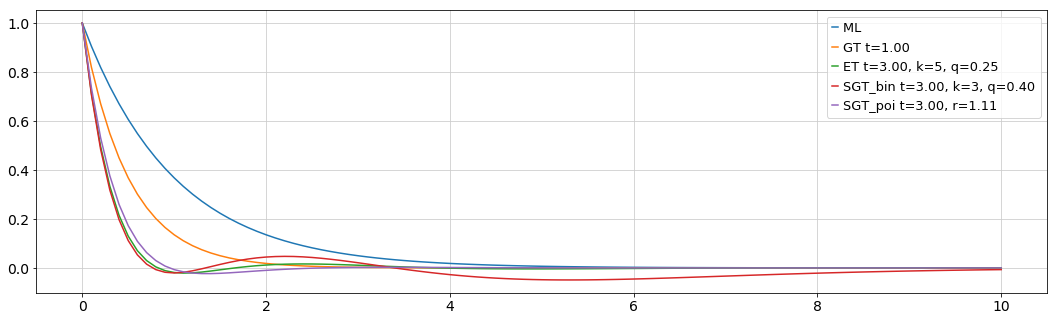

In [300]:
sd.visualize_zero_component_estimator()

### Correctness check: on a toy example

In [301]:
## testing on a toy example
data,X,p0_true,size_factor = load_toy_ann_data()
print(p0_true)
Y = np.array(data.X.todense(),dtype=int)

[[0.4 0.2 0. ]
 [0.2 0.6 0. ]
 [0.  0.  0. ]]


In [302]:
w = sd.zero_component_estimator(20)
print(w[7])

-0.0


In [314]:
## sanity check
p0_dd_,p0_ml_,gene_name = sd.dd_zero_anndata(data,verbose=True)
w = sd.zero_component_estimator(20)
w = np.concatenate([w,np.zeros([100])])
for i in range(3):
    p0_dd = 0
    for i_row in range(Y.shape[0]):
        p0_dd += w[Y[i_row,i]]
    p0_dd = p0_dd/Y.shape[0]
    p0_ml =np.mean(Y[:,i]==0)
    print('dd i=%d, val=%0.2f, true val=%0.2f'%(i,p0_dd_[i],p0_dd))        
    print('ml i=%d, val=%0.2f, true val=%0.2f'%(i,p0_ml_[i],p0_ml))

# time start: 0.0s
n_cell=10000, n_gene=3
# total time: 0.0s
dd i=0, val=0.43, true val=0.43
ml i=0, val=0.47, true val=0.47
dd i=1, val=0.61, true val=0.61
ml i=1, val=0.65, true val=0.65
dd i=2, val=0.00, true val=0.00
ml i=2, val=0.00, true val=0.00


In [311]:
zero_matrix_dd,zero_matrix_ml,gene_name = sd.dd_pairwise_zero_anndata(data)
print('# Sanity check')
w = sd.zero_component_estimator(20)
w = np.concatenate([w,np.zeros([100])])
for i in range(3):
    for j in range(i+1,3):
        p0_dd = 0
        p0_ml = 0
        for i_row in range(Y.shape[0]):
            p0_dd += w[Y[i_row,i]] * w[Y[i_row,j]]
            if Y[i_row,i]==0 and Y[i_row,j]==0:
                p0_ml+=1
        p0_dd = p0_dd/Y.shape[0]
        p0_ml = p0_ml/Y.shape[0]
        print('dd i=%d, j=%d, val=%0.4f, true val=%0.4f'%(i,j,zero_matrix_dd[i,j],p0_dd))        
        print('ml i=%d, j=%d, val=%0.4f, true val=%0.4f'%(i,j,zero_matrix_ml[i,j],p0_ml))

#time start: 0.0s
n_cell=10000, n_gene=3
# total time: 0.008s
# Sanity check
dd i=0, j=1, val=0.2161, true val=0.2161
ml i=0, j=1, val=0.2700, true val=0.2700
dd i=0, j=2, val=0.0004, true val=0.0004
ml i=0, j=2, val=0.0000, true val=0.0000
dd i=1, j=2, val=-0.0004, true val=-0.0004
ml i=1, j=2, val=0.0000, true val=0.0000


### Speed check: benchmark on the 4k data
- remove the high count elements 
- cython implementation

In [285]:
## benchmark on the 4k data
data_4k = load_10x_4k()
sc.pp.filter_genes(data_4k,min_counts=5*data_4k.shape[0],copy=False)
sc.pp.subsample(data_4k,fraction=0.05,copy=False)
data_4k.shape

(217, 132)

In [289]:
_ = sd.dd_zero_anndata(data_4k,verbose=True)

# time start: 0.0s
n_cell=217, n_gene=132
# total time: 0.0s


In [265]:
_ = sd.dd_pairwise_zero_anndata(data_4k)

#time start: 0.0s
n_cell=217, n_gene=132
# total time: 0.057s


In [290]:
_ = sd.dd_pairwise_zero_anndata(data_4k)

#time start: 0.0s
n_cell=217, n_gene=132
# total time: 0.050s


In [306]:
## benchmark on the 4k data
data_4k = load_10x_4k()
sc.pp.filter_genes(data_4k,min_counts=0.01*data_4k.shape[0],copy=False)
# sc.pp.subsample(data_4k,fraction=0.2,copy=False)
data_4k.shape

(4340, 10860)

In [321]:
_ = sd.dd_zero_anndata(data_4k,verbose=True)

# time start: 0.0s
n_cell=4340, n_gene=10860
# total time: 0.3s


In [267]:
_ = sd.dd_pairwise_zero_anndata(data_4k)

#time start: 0.0s
n_cell=4340, n_gene=810
# total time: 13.022s


In [298]:
_ = sd.dd_pairwise_zero_anndata(data_4k)

#time start: 0.0s
n_cell=4340, n_gene=810
# total time: 15.899s


In [167]:
_ = sd.dd_pairwise_zero_anndata(data_4k)

#time start: 0.0s
n_cell=4340, n_gene=810
# check time: 1096.563s
# total time: 1096.671s
